In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install python_speech_features
!pip install scipy

  Preparing metadata (setup.py) ... - done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=743982d1a4af9bd52e4d737226cb8e47ba9b68474fe28d206ee4a268dd6d3cbe
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python_speech_features


In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
import librosa
import librosa.display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier

In [4]:
def parse_audio(x):
    return x.flatten('F')[:x.shape[0]]

In [5]:
data_directory = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
genre = "pop"

pop_songs = os.listdir(data_directory + "/" + genre + "/")


In [6]:
x, sr = sf.read(data_directory + "/" + "pop" + "/" + pop_songs[0], always_2d=True)

In [7]:
mfcc_object = mfcc(x, sr)

In [8]:
len(x)

661504

In [9]:
sr

22050

In [10]:
data_directory = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

data = []
labels = []
bad_files = []

for folder in os.listdir(data_directory):
    for song in os.listdir(data_directory + "/" + folder):
        try:
            x, sr = sf.read(data_directory + "/" + folder + "/" + song, always_2d=True)
            x = parse_audio(x)
            mfcc_feat = mfcc(x, sr, winlen = 0.020, appendEnergy=False)
            means = mfcc_feat.mean(0)
            data.append(means)
            labels.append(folder)
        except Exception:
            bad_files.append(song)
        

In [11]:
X = np.array(data)
Y = labels

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

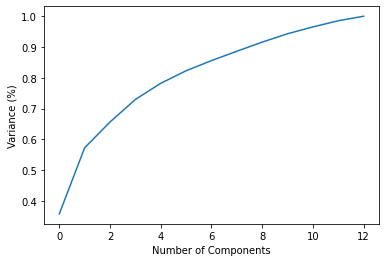

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [14]:
df = pd.DataFrame(X_train_scaled)
df['target'] = y_train

In [15]:
vals = df.loc[:, df.columns != 'target'].values

In [16]:
labs = df['target'].values

In [17]:
le = LabelEncoder()
labs_encoded = le.fit_transform(labs)

In [18]:
model = XGBClassifier()
model.fit(vals, labs_encoded)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [19]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model = GridSearchCV(XGBClassifier(), params, cv=5, n_jobs=-1)
model.fit(vals, labs_encoded)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [20]:
y_predict = model.predict(X_test_scaled)
y_predict_decoded = le.inverse_transform(y_predict)
print(f'Confusion Matrix: \n{confusion_matrix(y_predict_decoded, y_test)}')

Confusion Matrix: 
[[14  0  1  1  0  2  2  0  2  1]
 [ 0 23  1  1  0  1  0  0  0  0]
 [ 2  0  7  1  1  0  0  1  2  2]
 [ 1  2  0 15  3  1  1  1  2  0]
 [ 2  0  1  3  9  0  1  0  6  1]
 [ 3  0  5  1  2 14  1  2  2  1]
 [ 2  0  0  0  2  0 17  0  0  0]
 [ 0  0  2  0  3  0  0 21  1  0]
 [ 2  0  1  0  5  2  0  0 13  2]
 [ 3  0  6  6  1  2  1  0  0 13]]


In [21]:
f1_score(y_predict_decoded, y_test, average="weighted")

0.5880219771279229